In [ ]:
#hide
#all_slow

# Training ResNet18-UNET

> Training notebook for this architecture.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/11_resnet18-UNET.ipynb)

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [181]:
from steel_segmentation.all import *

import cv2
import fastai
import torch
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import albumentations as alb
import segmentation_models_pytorch as smp

In [3]:
fastai.__version__, torch.__version__

('2.2.3', '1.7.1+cu101')

In [4]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [5]:
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [6]:
torch.cuda.empty_cache()

In [7]:
!nvidia-smi

Mon Apr  5 18:48:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   25C    P8    12W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Actually testing the `get_segmnt_dls` Dataloader with `unet_learner` and `Learner` with `smp.Unet` architecure.

## Dataloader

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [228]:
img_id = train_pfiles[110].name; img_id

'fa347a114.jpg'

In [229]:
img = cv2.imread(str(train_path/img_id))

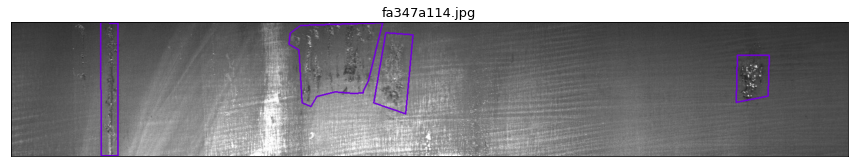

In [230]:
_, mask = make_mask(img_id); 
plot_mask_image(img_id, img, mask)

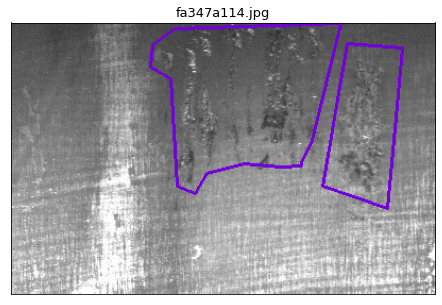

In [231]:
crop_aug = alb.CropNonEmptyMaskIfExists(256, 400, p=1., ignore_values=[0])
cropped = crop_aug(image=img, mask=mask)
image_cropped = cropped["image"]
mask_cropped = cropped["mask"]
plot_mask_image(img_id, image_cropped, mask_cropped)

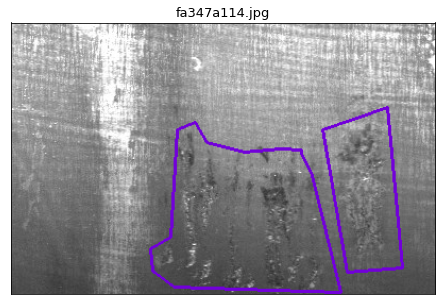

In [232]:
vaug = alb.VerticalFlip(p=1)

v_flipped = vaug(image=image_cropped, mask=mask_cropped)
image_v_flipped = v_flipped["image"]
mask_v_flipped = v_flipped["mask"]
plot_mask_image(img_id, image_v_flipped, mask_v_flipped)

In [269]:
def train_aug(): return alb.Compose([
    alb.RandomCrop(256, 400, always_apply=True, p=1.),
#    alb.CropNonEmptyMaskIfExists(height=256, width=400),
    alb.OneOf([
        alb.VerticalFlip(p=0.5),
        alb.HorizontalFlip(p=0.5)
    ], p=0.5),
    alb.OneOf([
        alb.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        alb.GridDistortion(p=0.5),
        #alb.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.5)
], )

In [270]:
tfm_train = train_aug()

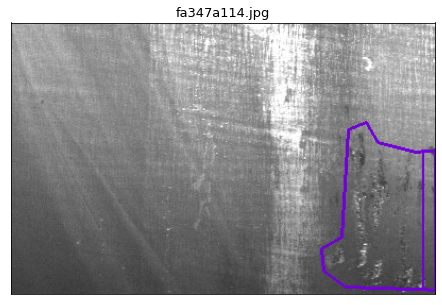

In [291]:
tfm_train_dict = tfm_train(image=img, mask=mask)
tfm_img_train = tfm_train_dict['image']
tfm_mask_train = tfm_train_dict['mask']
plot_mask_image(img_id, tfm_img_train, tfm_mask_train)

In [272]:
def valid_aug(): return alb.Compose([
    alb.RandomCrop(256, 400, always_apply=True, p=1.)
])

In [286]:
tfm_valid = valid_aug()

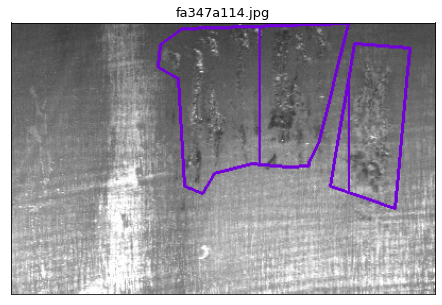

In [288]:
tfm_valid_dict = tfm_valid(image=img, mask=mask)
tfm_img_valid = tfm_valid_dict['image']
tfm_mask_valid = tfm_valid_dict['mask']
plot_mask_image(img_id, tfm_img_valid, tfm_mask_valid)

In [275]:
alb_tfm = [AlbumentationsTransform(tfm_train, tfm_valid)]

In [318]:
dls = get_segmnt_dls(train_pivot, bs=16, itfms=alb_tfm, flatten_mask=True)

In [319]:
x, targ = dls.train.one_batch()
x.shape, targ.shape

(torch.Size([16, 3, 256, 400]), torch.Size([16, 256, 400]))

In [278]:
x, targ = dls.valid.one_batch()
x.shape, targ.shape

(torch.Size([16, 3, 256, 400]), torch.Size([16, 4, 256, 400]))

In [279]:
x.device, targ.device

(device(type='cuda', index=0), device(type='cpu'))

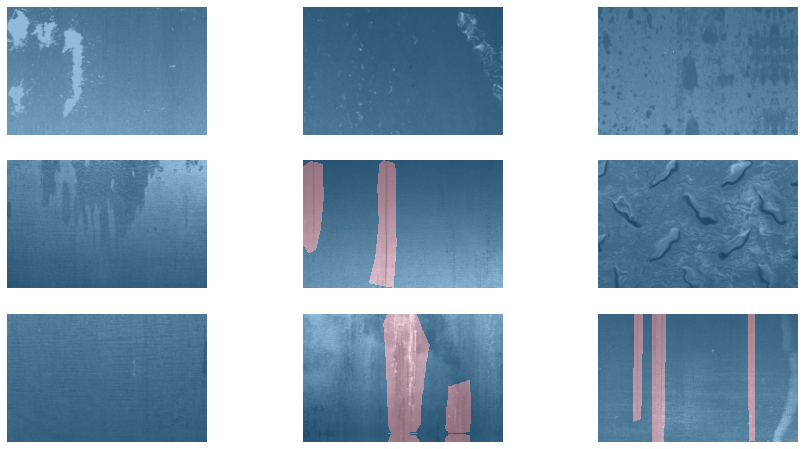

In [282]:
dls.show_batch(figsize=(15,8))

## Pytorch Learner

In [306]:
arch = smp.FPN('resnet18', classes=4, activation=None)

In [320]:
arch = smp.Unet('resnet18', classes=4, activation=None)

In [307]:
def opt_func(params, **kwargs): return OptimWrapper(torch.optim.Adam(params, **kwargs))

In [308]:
def splitter(m): return convert_params([[m.encoder], [m.decoder], [m.segmentation_head]])

In [321]:
learn = Learner(dls=dls, 
                model=arch, 
                loss_func=MultiClassesSoftBCEDiceLoss(),
                metrics=[ModDiceMulti], 
                splitter=splitter, 
                opt_func=opt_func, 
                model_dir=models_dir, 
                cbs=[CudaCallback(), ShowGraphCallback()])

In [322]:
learn.summary()

RuntimeError: Sizes of tensors must match except in dimension 3. Got 25 and 26 (The offending index is 0)

In [83]:
learn.freeze_to(-2)

In [301]:
learn.fit(1)

epoch,train_loss,valid_loss,mod_dice_multi,time


RuntimeError: Sizes of tensors must match except in dimension 3. Got 25 and 26 (The offending index is 0)

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,mod_dice_multi,time
0,0.089152,0.090094,0.009968,00:55


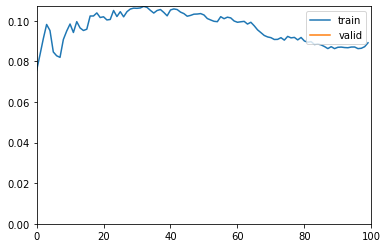

In [ ]:
learn.fit(1)

## Fastai Learner

In [303]:
fast_learner = unet_learner(dls=dls, arch=resnet18, loss_func=MultiClassesSoftBCEDiceLoss(),
                            metrics=[ModDiceMulti], model_dir=models_dir, 
                            cbs=[CudaCallback(), ShowGraphCallback()])

In [305]:
fast_learner.summary()

DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 128 x 200 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                     

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=5.248074739938602e-05)

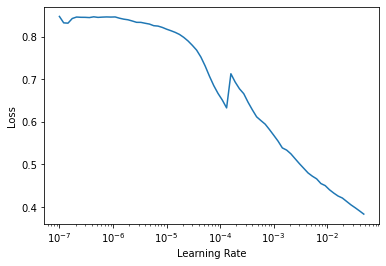

In [ ]:
fast_learner.lr_find()